# Feature-based predictor
This notebook is based on [Andrew Lukyanenko](https://www.kaggle.com/artgor)'s [kernel](https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples).

## General information
Correctly predicting earthquakes is very important for preventing deaths and damage to infrastructure. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data. Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

## Preliminaries
Let's import everything we need:

In [1]:
import gc
import os
import time
import random
import datetime
import warnings

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from catboost import CatBoostRegressor
from scipy import stats
from scipy.signal import hilbert, hann, convolve
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from utils import freq_from_crossings, freq_from_fft

In [2]:
%matplotlib inline
pd.options.display.precision = 15
warnings.filterwarnings('ignore')
random.seed(1013)

## Training data

In [3]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
fs = 4000000

CPU times: user 1min 19s, sys: 3.5 s, total: 1min 23s
Wall time: 1min 23s


In [4]:
print(f'Train: rows:{train.shape[0]} cols:{train.shape[1]}')

Train: rows:629145480 cols:2


In [5]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121
5,8,1.469099998474121
6,9,1.469099998474121
7,7,1.469099998474121
8,-5,1.469099998474121
9,3,1.469099998474121


Let's visualize it

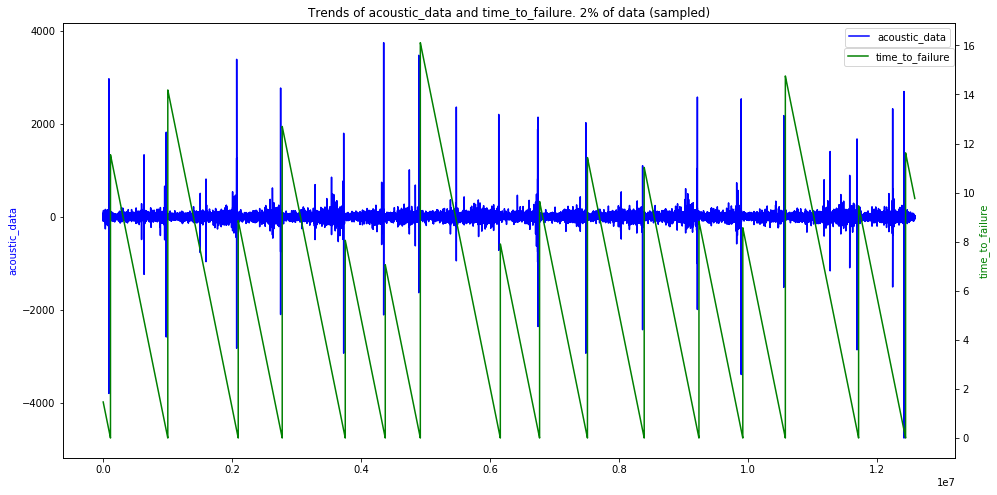

In [6]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('Trends of acoustic_data and time_to_failure. 2% of data (sampled)')
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

- We can see that usually acoustic data shows huge fluctuations just before the failure and the nature of data is cyclical;
- Another important point: visually failures can be predicted as cases when huge fluctuations in signal are followes by small signal values. This could be useful for predicting `time_to_failure` changes from 0 to high values;
- I thought that comparing max values of signal in a segment to some threshold value (1000 or 2000) could be useful, but it didn't work;

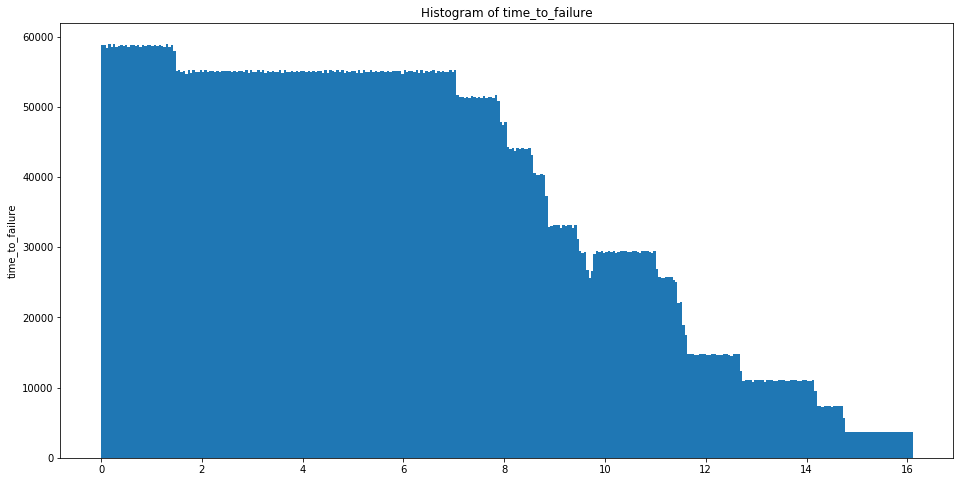

In [7]:
plt.figure(figsize=(16, 8))
plt.hist(train['time_to_failure'].values[::50], bins='auto')  # arguments are passed to np.histogram
plt.title('Histogram of time_to_failure')
plt.ylabel('time_to_failure')
plt.show()

- The time to training is not uniforally distribured on the training set. Resampling could be interesting.

## Feature generation
- Usual aggregations: mean, std, min and max;
- Average difference between the consequitive values in absolute and percent values;
- Absolute min and max vallues;
- Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
- Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
- Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
- Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
- Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [8]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

In [9]:
def classic_sta_lta(x, length_sta, length_lta, show=False, method='Andrew'):
    if method=='Andrew':
        sta = np.cumsum(x ** 2)
        # Convert to float
        sta = np.require(sta, dtype=np.float)
        # Copy for LTA
        lta = sta.copy()
        # Compute the STA and the LTA
        sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
        sta /= length_sta
        lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
        lta /= length_lta
        # Pad zeros
        sta[:length_lta - 1] = 0
        # Avoid division by zero by setting zero values to tiny float
        dtiny = np.finfo(0.0).tiny
        idx = lta < dtiny
        lta[idx] = dtiny
        ratio_andrew = sta / lta
    elif method == 'Ricard':
        x_abs = np.abs(x)
        # Convert to float
        x_abs = np.require(x_abs, dtype=np.float)
        # Compute the STA and the LTA
        sta = np.cumsum(x_abs)
        sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
        sta = sta[length_sta - 1:] / length_sta
        sta = sta[:-(length_lta-length_sta)]
        lta = x_abs.copy()
        lta = np.cumsum(lta)
        lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
        lta = lta[length_lta - 1:] / length_lta

        ratio = sta / lta
    
    if show:
        plt.subplots(figsize=(16, 8))
        plt.subplot(4, 1, 1)
        plt.plot(x)
        plt.ylabel('x')
        plt.subplot(4, 1, 2)
        plt.plot(sta)
        plt.ylabel('sta')
        plt.subplot(4, 1, 3)
        plt.plot(lta)
        plt.ylabel('lta')
        plt.subplot(4, 1, 4)
        plt.plot(ratio)
        plt.ylabel('sta / lta')

    return ratio

In [10]:
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [11]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    # Generic stats
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    # rdg: mean_change_abs corrected
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.abs(np.diff(xc)))
    X.loc[seg_id, 'mean_change_rate'] = calc_change_rate(xc)
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    # Classical stats by segment
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = calc_change_rate(xc[:50000])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = calc_change_rate(xc[-50000:])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = calc_change_rate(xc[:10000])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = calc_change_rate(xc[-10000:])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()    
    
    sta_lta_method = 'Ricard'
    classic_sta_lta1 = classic_sta_lta(xc, 500, 10000, method=sta_lta_method)
    classic_sta_lta2 = classic_sta_lta(xc, 5000, 100000, method=sta_lta_method)
    classic_sta_lta3 = classic_sta_lta(xc, 3333, 6666, method=sta_lta_method)
    classic_sta_lta4 = classic_sta_lta(xc, 10000, 25000, method=sta_lta_method)
    classic_sta_lta5 = classic_sta_lta(xc, 50, 1000, method=sta_lta_method)
    classic_sta_lta6 = classic_sta_lta(xc, 100, 5000, method=sta_lta_method)
    classic_sta_lta7 = classic_sta_lta(xc, 333, 666, method=sta_lta_method)
    classic_sta_lta8 = classic_sta_lta(xc, 4000, 10000, method=sta_lta_method)
    
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta1.mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta2.mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta3.mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta4.mean()
    X.loc[seg_id, 'classic_sta_lta5_mean'] = classic_sta_lta5.mean()
    X.loc[seg_id, 'classic_sta_lta6_mean'] = classic_sta_lta6.mean()
    X.loc[seg_id, 'classic_sta_lta7_mean'] = classic_sta_lta7.mean()
    X.loc[seg_id, 'classic_sta_lta8_mean'] = classic_sta_lta8.mean()

    X.loc[seg_id, 'classic_sta_lta1_q95'] = np.quantile(classic_sta_lta1, 0.95)
    X.loc[seg_id, 'classic_sta_lta2_q95'] = np.quantile(classic_sta_lta2, 0.95)
    X.loc[seg_id, 'classic_sta_lta3_q95'] = np.quantile(classic_sta_lta3, 0.95)
    X.loc[seg_id, 'classic_sta_lta4_q95'] = np.quantile(classic_sta_lta4, 0.95)
    X.loc[seg_id, 'classic_sta_lta5_q95'] = np.quantile(classic_sta_lta5, 0.95)
    X.loc[seg_id, 'classic_sta_lta6_q95'] = np.quantile(classic_sta_lta6, 0.95)
    X.loc[seg_id, 'classic_sta_lta7_q95'] = np.quantile(classic_sta_lta7, 0.95)
    X.loc[seg_id, 'classic_sta_lta8_q95'] = np.quantile(classic_sta_lta8, 0.95)   

    X.loc[seg_id, 'classic_sta_lta1_q05'] = np.quantile(classic_sta_lta1, 0.05)
    X.loc[seg_id, 'classic_sta_lta2_q05'] = np.quantile(classic_sta_lta2, 0.05)
    X.loc[seg_id, 'classic_sta_lta3_q05'] = np.quantile(classic_sta_lta3, 0.05)
    X.loc[seg_id, 'classic_sta_lta4_q05'] = np.quantile(classic_sta_lta4, 0.05)
    X.loc[seg_id, 'classic_sta_lta5_q05'] = np.quantile(classic_sta_lta5, 0.05)
    X.loc[seg_id, 'classic_sta_lta6_q05'] = np.quantile(classic_sta_lta6, 0.05)
    X.loc[seg_id, 'classic_sta_lta7_q05'] = np.quantile(classic_sta_lta7, 0.05)
    X.loc[seg_id, 'classic_sta_lta8_q05'] = np.quantile(classic_sta_lta8, 0.05)

    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)

    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_6000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=30000).mean().mean(skipna=True)

    # rdg: TODO it seems a parameter to tune
    no_of_std = 3
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id, 'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean']
                                              + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean']
                                             - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id, 'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean']
                                              + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean']
                                             - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc, 0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc, 0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)

    # rdg: The frequency features are new
    X.loc[seg_id, 'freq_cross_first_50000'] = freq_from_crossings(xc.values[:50000], fs)
    X.loc[seg_id, 'freq_cross_last_50000'] = freq_from_crossings(xc.values[-50000:], fs)
    X.loc[seg_id, 'freq_cross_first_10000'] = freq_from_crossings(xc.values[:10000], fs)
    X.loc[seg_id, 'freq_cross_last_10000'] = freq_from_crossings(xc.values[-10000:], fs)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.abs(np.diff(x_roll_std)))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = calc_change_rate(pd.Series(x_roll_std))
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.abs(np.diff(x_roll_mean)))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = calc_change_rate(pd.Series(x_roll_mean))
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

## Sampling the training set
Since the testign set is build of sequences of 150.000 samples, let's chop the training set on comparable chunks. 

In [12]:
# Create a training file with simple derived features
segment_size = 150000

In [13]:
def generate_segment_start_ids(sampling_method):
    if sampling_method == 'uniform':
        # With this approach we obtain 4194 segments
        num_segments_training = int(np.floor(train.shape[0] / segment_size))
        segment_start_ids = [i * segment_size for i in range(num_segments_training)]
    elif sampling_method == 'uniform_no_jump':
        # With this approach we obtain 4178 segments (99.5% of 'uniform')
        already_sampled = np.full(train.shape[0], False)
        num_segments_training = int(np.floor(train.shape[0] / segment_size))
        time_to_failure_jumps = np.diff(train['time_to_failure'].values)
        num_good_segments_found = 0
        segment_start_ids = []
        for i in range(num_segments_training):
            idx = i * segment_size
            # Detect if there is a discontinuity on the time_to_failure signal within the segment
            max_jump = np.max(time_to_failure_jumps[idx:idx + segment_size])
            if max_jump < 5:
                segment_start_ids.append(idx)
                num_good_segments_found += 1
            else:
                print(f'Rejected candidate segment since max_jump={max_jump}')
        segment_start_ids.sort()
    elif sampling_method == 'random_no_jump':
        # With this approach we obtain 4194 segments
        num_segments_training = int(np.floor(train.shape[0] / segment_size)) #arbitrary choice
        time_to_failure_jumps = np.diff(train['time_to_failure'].values)
        num_good_segments_found = 0
        segment_start_ids = []
        while num_segments_training != num_good_segments_found:
            # Generate a random sampling position
            idx = random.randint(0, train.shape[0] - segment_size - 1)
            # Detect if there is a discontinuity on the time_to_failure signal within the segment
            max_jump = np.max(time_to_failure_jumps[idx:idx + segment_size])
            if max_jump < 5:
                segment_start_ids.append(idx)
                num_good_segments_found += 1
            else:
                print(f'Rejected candidate segment since max_jump={max_jump}')
        segment_start_ids.sort()
    else:
        raise NameError('Method does not exist')
    return segment_start_ids

Currently, we have two strategies implemented.
- Uniform sampling: Here the training set is built from consecutive chunks of data. No special care is taken into what's the content of each segment.
- Uniform sampling with rejection: Here the training set is built from consecutive chunks of data. There is a control to avoid having in a segment the jump of the `time_to_failure` signal from zero to a high value.
- Random sampling with rejection: Here the training set is built from sampling randomly the data. There is a control to avoid having in a segment the jump of the `time_to_failure` signal from zero to a high value. The segments will most likely overlap.

Let's visualize what happens to the distribution of the `time_to_failure` on teh different samplign strategies:

Generating uniformly sampled training set
Generating uniformly sampled training set excluding discontinuities in time_to_failure.
Rejected candidate segment since max_jump=11.54000473022461
Rejected candidate segment since max_jump=14.17990493774414
Rejected candidate segment since max_jump=8.855904579162598
Rejected candidate segment since max_jump=12.692904472351074
Rejected candidate segment since max_jump=8.05490493774414
Rejected candidate segment since max_jump=7.0579047203063965
Rejected candidate segment since max_jump=16.106904983520508
Rejected candidate segment since max_jump=7.904904365539551
Rejected candidate segment since max_jump=9.6369047164917
Rejected candidate segment since max_jump=11.425904273986816
Rejected candidate segment since max_jump=11.024004936218262
Rejected candidate segment since max_jump=8.828004837036133
Rejected candidate segment since max_jump=8.56590461730957
Rejected candidate segment since max_jump=14.750904083251953
Rejected candidate segment s

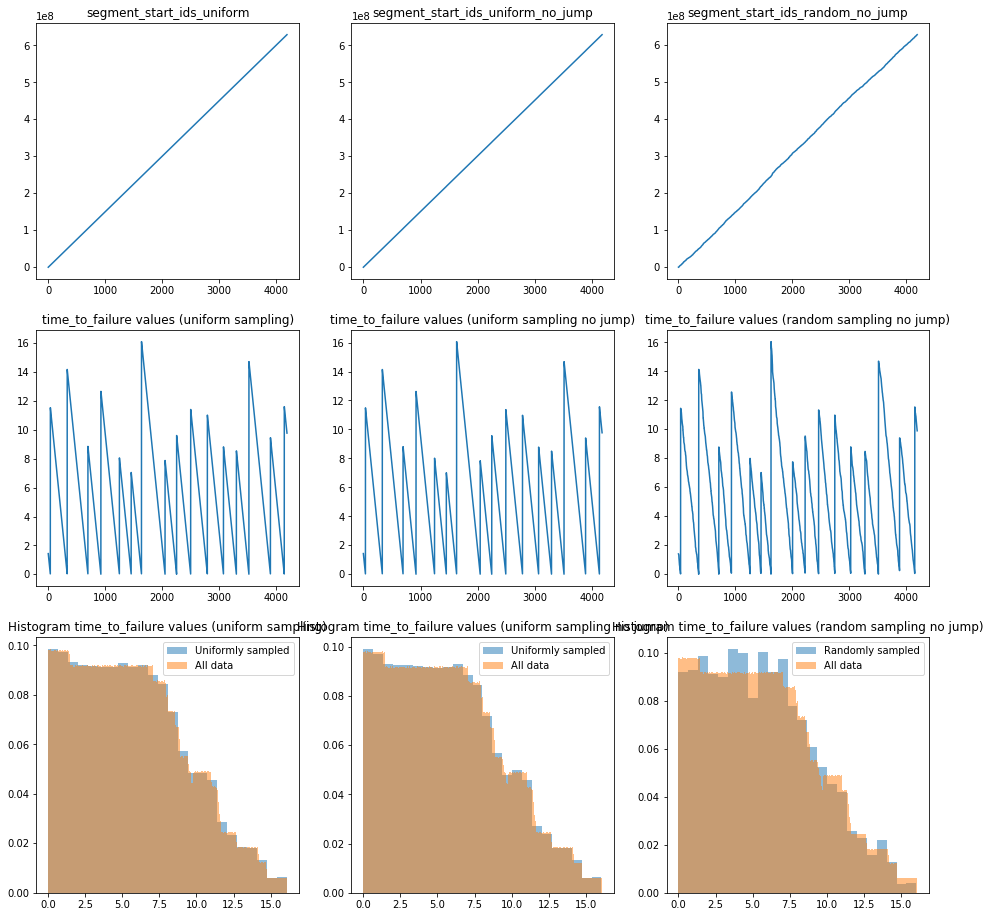

In [14]:
print(f'Generating uniformly sampled training set')
segment_start_ids_uniform = generate_segment_start_ids('uniform')

print(f'Generating uniformly sampled training set excluding discontinuities in time_to_failure.')
segment_start_ids_uniform_no_jump = generate_segment_start_ids('uniform_no_jump')

print(f'Generating randomly sampled training set excluding discontinuities in time_to_failure.')
print(f'This method may yield overlaping segments')
segment_start_ids_random_no_jump = generate_segment_start_ids('random_no_jump')


y_tr_samples_uniform = train['time_to_failure'].values[np.array(
    segment_start_ids_uniform) + segment_size - 1]
y_tr_samples_uniform_no_jump = train['time_to_failure'].values[
    np.array(segment_start_ids_uniform_no_jump) + segment_size - 1]
y_tr_samples_random_no_jump = train['time_to_failure'].values[
    np.array(segment_start_ids_random_no_jump) + segment_size - 1]

plt.subplots(figsize=(16, 16))
plt.subplot(3, 3, 1)
plt.plot(segment_start_ids_uniform)
plt.title('segment_start_ids_uniform')
plt.subplot(3, 3, 2)
plt.plot(segment_start_ids_uniform_no_jump)
plt.title('segment_start_ids_uniform_no_jump')
plt.subplot(3, 3, 3)
plt.plot(segment_start_ids_random_no_jump)
plt.title('segment_start_ids_random_no_jump')

plt.subplot(3, 3, 4)
plt.plot(y_tr_samples_uniform)
plt.title('time_to_failure values (uniform sampling)')
plt.subplot(3, 3, 5)
plt.plot(y_tr_samples_uniform_no_jump)
plt.title('time_to_failure values (uniform sampling no jump)')
plt.subplot(3, 3, 6)
plt.plot(y_tr_samples_random_no_jump)
plt.title('time_to_failure values (random sampling no jump)')

plt.subplot(3, 3, 7)
plt.hist(y_tr_samples_uniform, bins='auto', alpha=0.5, density=True)
plt.hist(train['time_to_failure'].values[::50], bins='auto', alpha=0.5, density=True)
plt.title('Histogram time_to_failure values (uniform sampling)')
plt.legend(['Uniformly sampled', 'All data'])

plt.subplot(3, 3, 8)
plt.hist(y_tr_samples_uniform_no_jump, bins='auto', alpha=0.5, density=True)
plt.hist(train['time_to_failure'].values[::50], bins='auto', alpha=0.5, density=True)
plt.title('Histogram time_to_failure values (uniform sampling no jump)')
plt.legend(['Uniformly sampled', 'All data'])

plt.subplot(3, 3, 9)
plt.hist(y_tr_samples_random_no_jump, bins='auto', alpha=0.5, density=True)
plt.title('Histogram time_to_failure values (random sampling no jump)')
plt.hist(train['time_to_failure'].values[::50], bins='auto', alpha=0.5, density=True)
plt.legend(['Randomly sampled', 'All data'])
plt.show()

del segment_start_ids_uniform
del segment_start_ids_uniform_no_jump
del segment_start_ids_random_no_jump
del y_tr_samples_uniform
del y_tr_samples_uniform_no_jump
del y_tr_samples_random_no_jump

Finally, we choose one sampling method (`uniform`) and run with it

In [15]:
segment_start_ids = generate_segment_start_ids('uniform_no_jump')

Rejected candidate segment since max_jump=11.54000473022461
Rejected candidate segment since max_jump=14.17990493774414
Rejected candidate segment since max_jump=8.855904579162598
Rejected candidate segment since max_jump=12.692904472351074
Rejected candidate segment since max_jump=8.05490493774414
Rejected candidate segment since max_jump=7.0579047203063965
Rejected candidate segment since max_jump=16.106904983520508
Rejected candidate segment since max_jump=7.904904365539551
Rejected candidate segment since max_jump=9.6369047164917
Rejected candidate segment since max_jump=11.425904273986816
Rejected candidate segment since max_jump=11.024004936218262
Rejected candidate segment since max_jump=8.828004837036133
Rejected candidate segment since max_jump=8.56590461730957
Rejected candidate segment since max_jump=14.750904083251953
Rejected candidate segment since max_jump=9.458905220031738
Rejected candidate segment since max_jump=11.61800479888916


In [16]:
X_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64)
y_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64, columns=['time_to_failure'])

Compute all features for all segments (WARNING: it takes time)

In [17]:
for idx in tqdm_notebook(range(len(segment_start_ids))):        
    seg_id = segment_start_ids[idx]
    seg = train.iloc[seg_id:seg_id + segment_size]
    create_features(idx, seg, X_tr)
    y_tr.loc[idx, 'time_to_failure'] = seg['time_to_failure'].values[-1]

HBox(children=(IntProgress(value=0, max=4178), HTML(value='')))

In [18]:
print(f'{X_tr.shape[0]} samples in new train data and {X_tr.shape[1]} columns.')

4178 samples in new train data and 179 columns.


Let's take a look of how some of these features look like

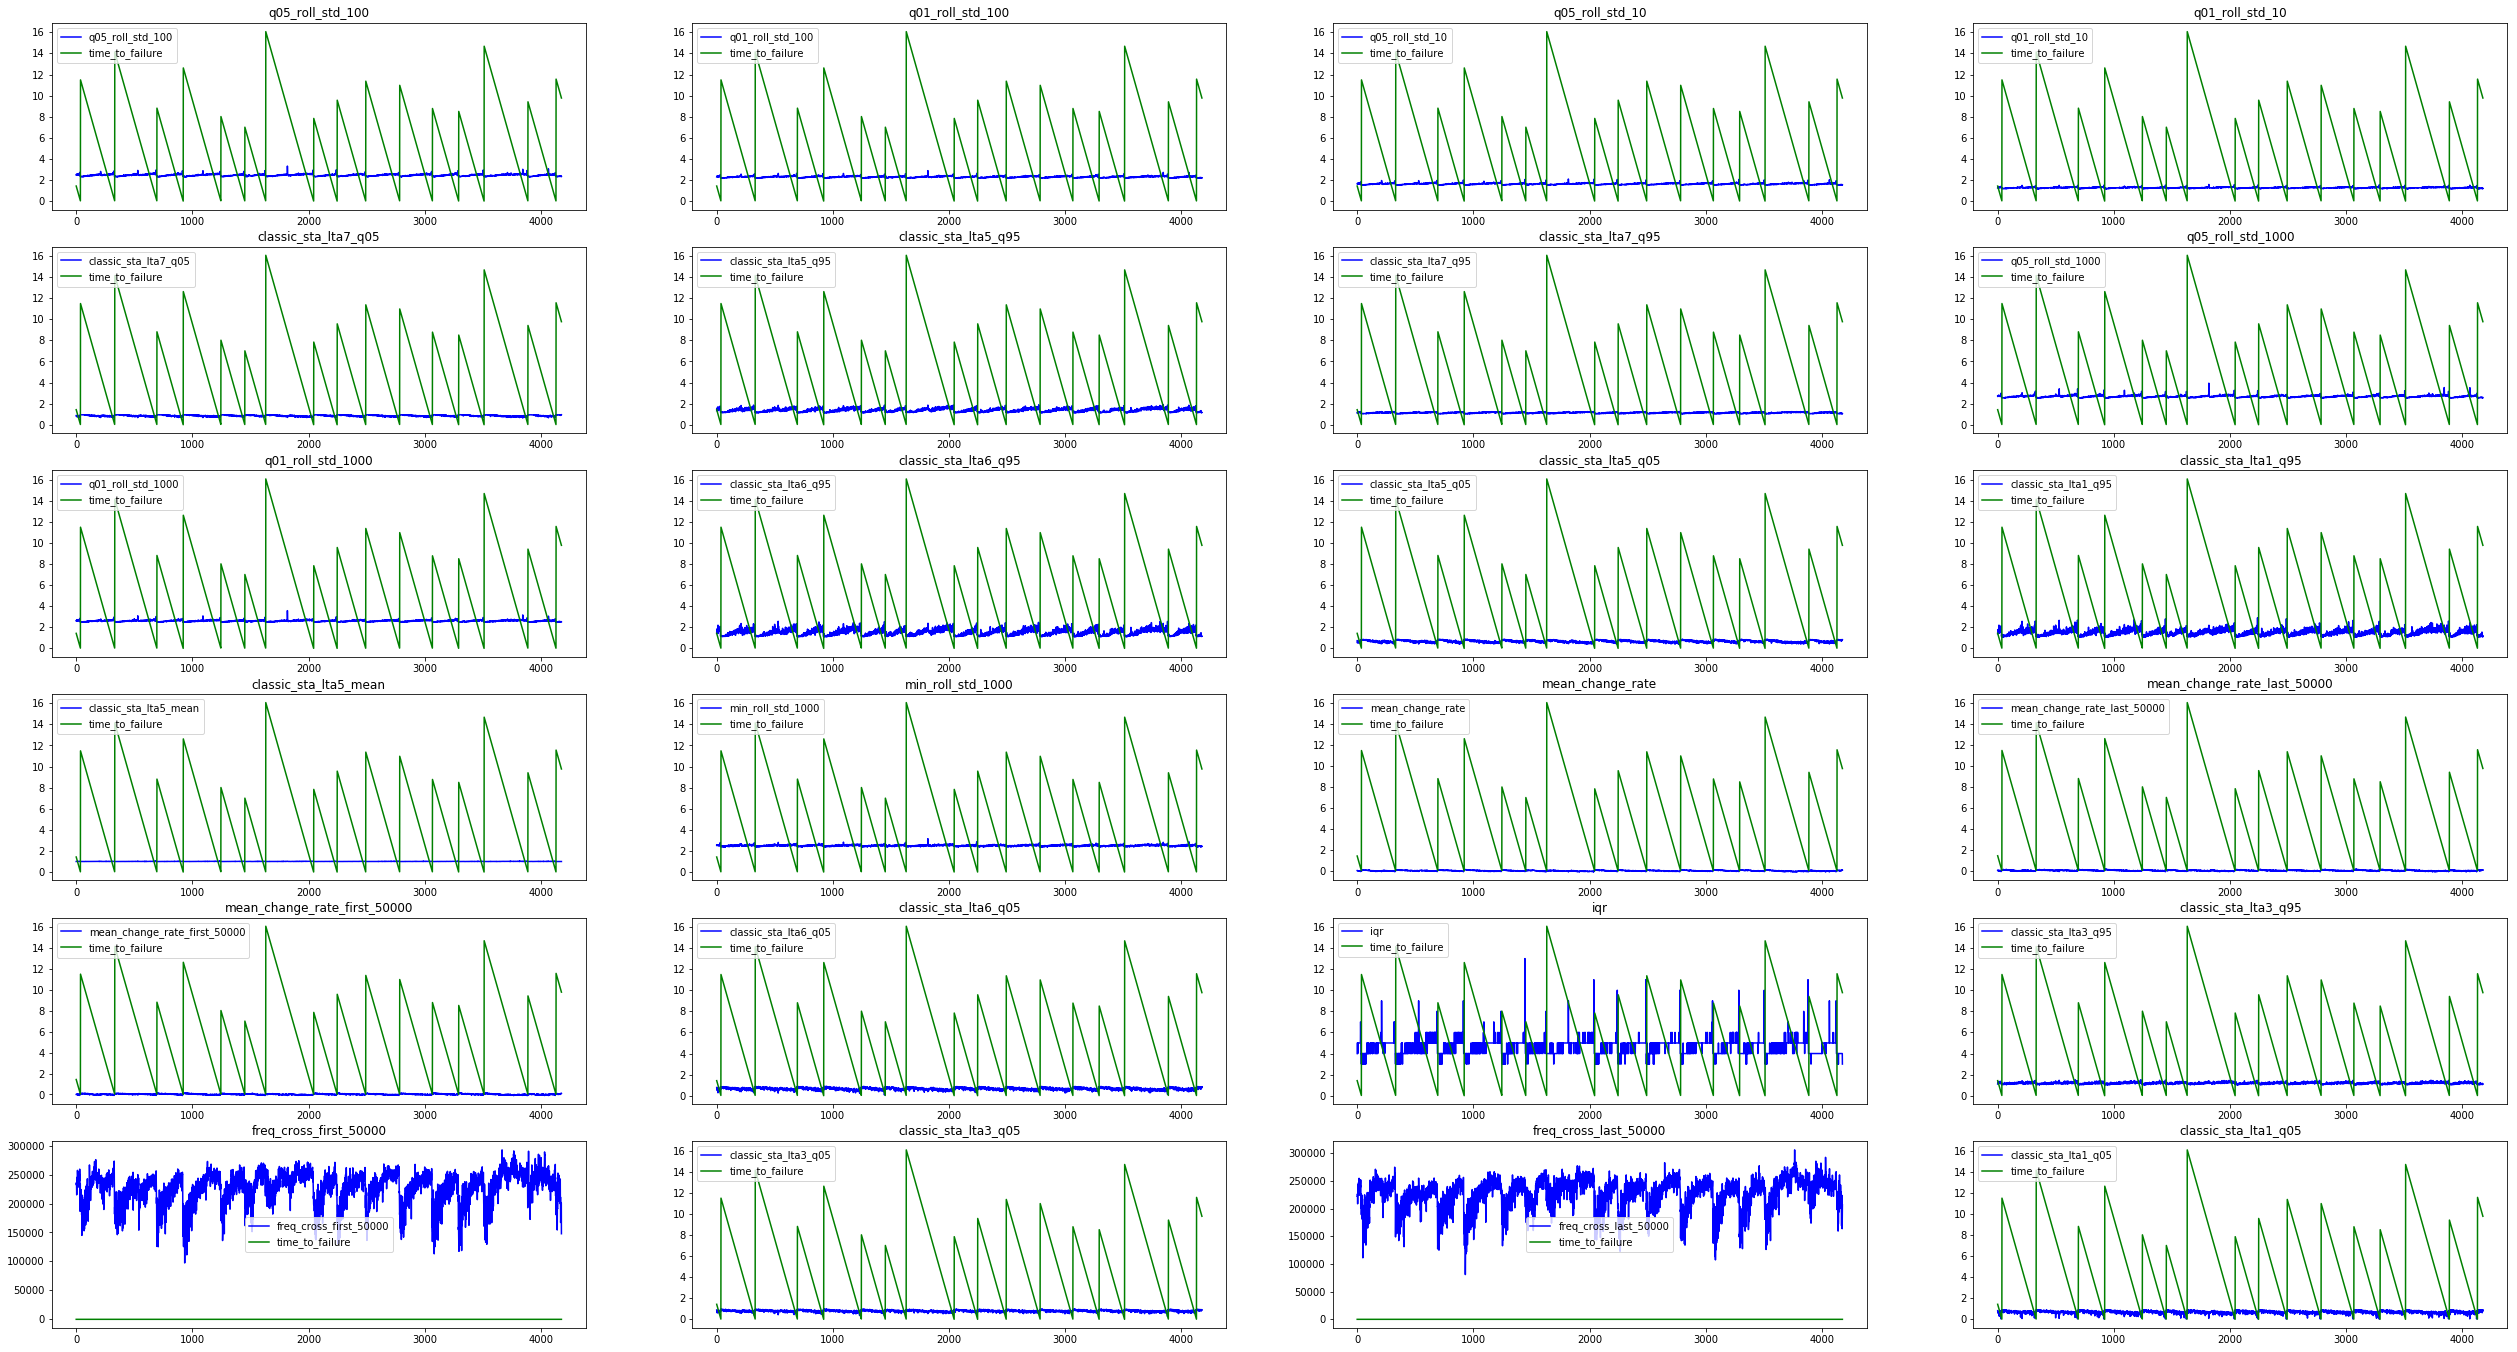

In [19]:
plt.subplots(figsize=(44, 24))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'])
    plt.grid(False)

Sometimes, there are features that exploded, which show as `np.inf` in the array. Let's just replace them by the mean values. TODO: check if this is the appropiate strategy. 

In [20]:
#means_dict = {}
for col in X_tr.columns:
    if X_tr[col].isnull().any():
        print(col)
#        mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
#        X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
#        X_tr[col] = X_tr[col].fillna(mean_value)
#        means_dict[col] = mean_value

In [21]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

## Reading test data

In [22]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)

In [23]:
plt.figure(figsize=(22, 16))
for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features(seg_id, seg, X_test)

HBox(children=(IntProgress(value=0, max=2624), HTML(value='')))

<Figure size 1584x1152 with 0 Axes>

In [24]:
# rdg: TODO - filling like this the empty spots is questionable
for col in X_test.columns:
    if X_test[col].isnull().any():
        print(col)
        #X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        #X_test[col] = X_test[col].fillna(means_dict[col])

In [25]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [26]:
X_test.head()

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780000000000,4.893689687028069,115.0,-75.0,4.000000000000000,2198.344035859719042,673767.0,-14758.442558580365585,-4.850638409455618e-16,1336.370644694053453,...,0.231890979668247,5.495,3.774,3.889,4.099,4.867,5.000,0.004754087248322,0.000001691085465,5.495
seg_0012b5,4.171153333333334,5.922839443206628,152.0,-140.0,5.000000000000000,2289.922378597143961,625673.0,-22626.387705690489383,3.637978807091713e-16,1621.103790631555967,...,0.230913661347393,5.009,3.342,3.644,3.790,4.541,4.739,0.005169295302013,0.000002160877546,5.009
seg_00184e,4.610260000000000,6.946990077490285,248.0,-193.0,7.999999999999996,2611.055629434194998,691539.0,-23593.939293521976651,6.790893773237864e-16,1899.881970018137736,...,0.247219261166618,6.234,3.544,4.013,4.215,4.966,5.082,0.005249959731544,0.000002474480967,6.234
seg_003339,4.531473333333333,4.114146602958288,85.0,-93.0,2.000000000000000,2085.543454354283767,679721.0,-11908.537958646624247,-8.488617216547330e-16,1126.745534714915038,...,0.224908762860213,5.446,3.889,4.032,4.184,4.911,5.051,0.003891375838926,0.000001844742393,5.446
seg_0042cc,4.128340000000000,5.797163636220498,177.0,-147.0,5.000000000000000,2243.929923148225043,619251.0,-24048.055869679606985,3.880510727564494e-16,1600.707499826248750,...,0.274025292743740,5.027,3.357,3.534,3.662,4.570,4.870,0.004879825503356,0.000001314410564,5.027


## Building models

In [27]:
def train_model(X, X_test, y, folds, params=None, model_type='lgb',
                model=None, show_scatter=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    n_fold = folds.get_n_splits()
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric='mae',
                      verbose=10000,
                      early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data,
                              num_boost_round=20000,
                              evals=watchlist,
                              early_stopping_rounds=200,
                              verbose_eval=500,
                              params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', task_type='GPU', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance['feature'] = X.columns
            fold_importance['importance'] = model.feature_importances_
            fold_importance['fold'] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    if show_scatter:
        fig, axis = plt.subplots(1, 2, figsize=(12,5))
        ax1, ax2 = axis
        ax1.set_xlabel('actual')
        ax1.set_ylabel('predicted')
        ax2.set_xlabel('train index')
        ax2.set_ylabel('time to failure')
        
        ax1.scatter(y, oof, color='brown')
        ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')

        ax2.plot(y, color='blue', label='y_train')
        ax2.plot(oof, color='orange')
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance['importance'] /= n_fold
        return oof, prediction, np.mean(scores), np.std(scores), feature_importance
    else:
        return oof, prediction, np.mean(scores), np.std(scores)


# Determine best features

In [28]:
n_fold_features = 5
folds_features = KFold(n_splits=n_fold_features, shuffle=True, random_state=11)

Fold 0 started at Fri Mar  8 12:43:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1175]	training's l1: 1.56387	valid_1's l1: 2.04445
Fold 1 started at Fri Mar  8 12:43:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1219]	training's l1: 1.54817	valid_1's l1: 2.02573
Fold 2 started at Fri Mar  8 12:44:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[985]	training's l1: 1.61246	valid_1's l1: 2.13879
Fold 3 started at Fri Mar  8 12:44:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[950]	training's l1: 1.6908	valid_1's l1: 1.88668
Fold 4 started at Fri Mar  8 12:44:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1435]	training's l1: 1.46632	valid_1's l1: 2.04648
CV mean score: 2.0284, std: 0.0811.


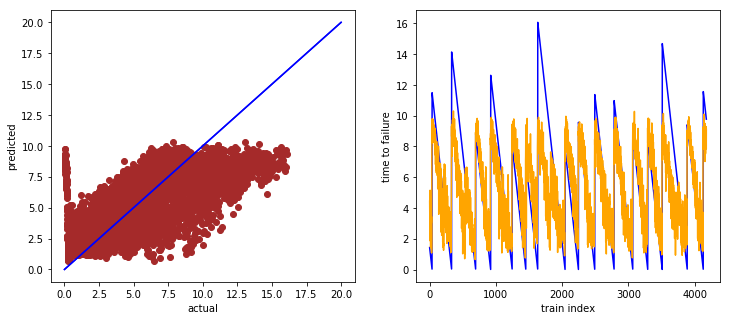

In [29]:
params = {'num_leaves': 54,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          'boosting': 'gbdt',
          'bagging_freq': 5,
          'bagging_fraction': 0.8126672064208567,
          'bagging_seed': 11,
          'metric': 'mae',
          'verbosity': -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, score_mean_lgb, score_std_lgb, feature_importance_lgb = train_model(
    X=X_train_scaled,
    X_test=X_test_scaled,
    y=y_tr,
    folds=folds_features,
    params=params,
    model_type='lgb',
    show_scatter=True)

# Feature selection

In [45]:
max_num_features = 179
cols_feat = (feature_importance_lgb[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:max_num_features].index)
best_features = feature_importance_lgb.loc[feature_importance_lgb.feature.isin(cols_feat)]

Text(0.5,1,'LightGBM Features (averaged over folds)')

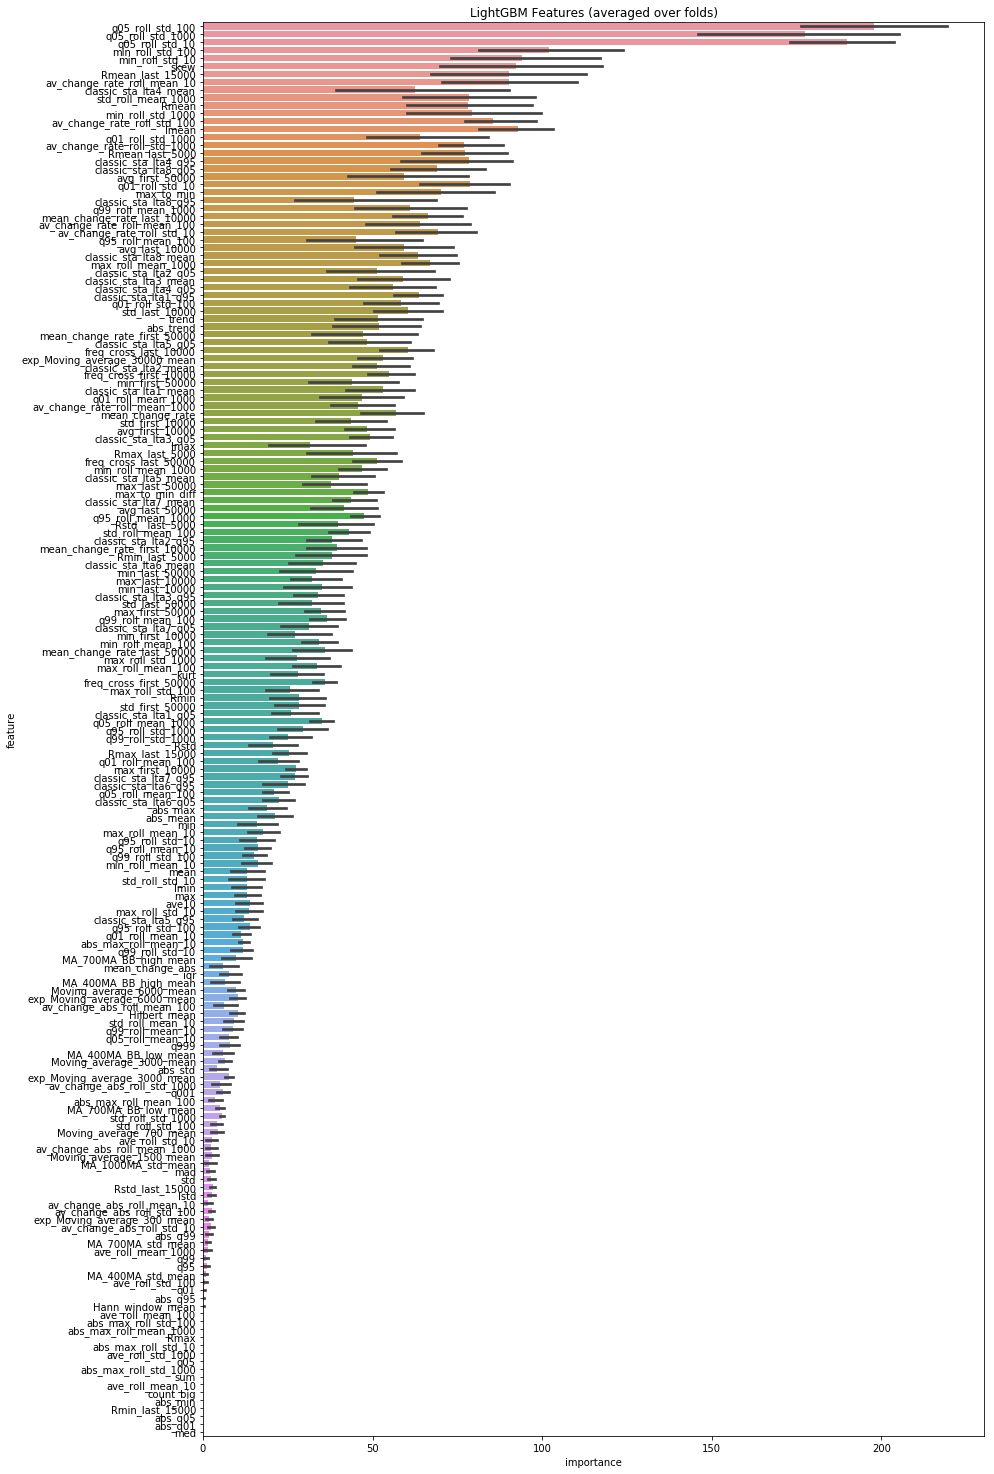

In [46]:
plt.figure(figsize=(14,26))
sns.barplot(x='importance', y='feature', data=feature_importance_lgb.sort_values(by='importance', ascending=False))
plt.title('LightGBM Features (averaged over folds)')

In [47]:
best_features_list = cols_feat.tolist()
X_train_scaled_best = X_train_scaled[best_features_list]
X_test_scaled_best = X_test_scaled[best_features_list]
n_fold_models = 5
folds_models = KFold(n_splits=n_fold_models, shuffle=True, random_state=11)

Fold 0 started at Fri Mar  8 14:30:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[960]	training's l1: 1.65427	valid_1's l1: 2.04788
Fold 1 started at Fri Mar  8 14:31:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1153]	training's l1: 1.57761	valid_1's l1: 2.02298
Fold 2 started at Fri Mar  8 14:31:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1082]	training's l1: 1.57757	valid_1's l1: 2.1353
Fold 3 started at Fri Mar  8 14:31:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[870]	training's l1: 1.73097	valid_1's l1: 1.89609
Fold 4 started at Fri Mar  8 14:31:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1281]	training's l1: 1.52202	valid_1's l1: 2.05742
CV mean score: 2.0319, std: 0.0776.


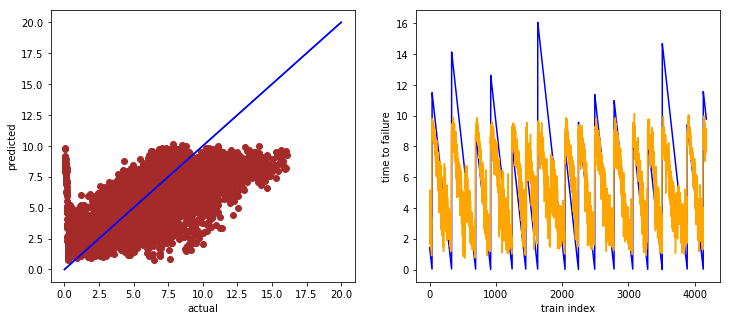

In [48]:
params = {'num_leaves': 54,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          'boosting': 'gbdt',
          'bagging_freq': 5,
          'bagging_fraction': 0.8126672064208567,
          'bagging_seed': 11,
          'metric': 'mae',
          'verbosity': -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, score_mean_lgb, score_std_lgb, feature_importance = train_model(X=X_train_scaled_best,
                                                                                         X_test=X_test_scaled_best,
                                                                                         y=y_tr,
                                                                                         folds=folds_models,
                                                                                         params=params,
                                                                                         model_type='lgb',
                                                                                         show_scatter=True)

Fold 0 started at Fri Mar  8 14:31:26 2019
[0]	train-mae:4.94896	valid_data-mae:4.94325
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[55]	train-mae:0.692684	valid_data-mae:2.10113

Fold 1 started at Fri Mar  8 14:31:31 2019
[0]	train-mae:4.97189	valid_data-mae:4.86239
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[57]	train-mae:0.64952	valid_data-mae:2.05753

Fold 2 started at Fri Mar  8 14:31:37 2019
[0]	train-mae:4.92077	valid_data-mae:5.06367
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[71]	train-mae:0.506196	valid_data-mae:2.19602

Fold 3 started at Fri Mar  8 14:31:43 2019
[0]	train-

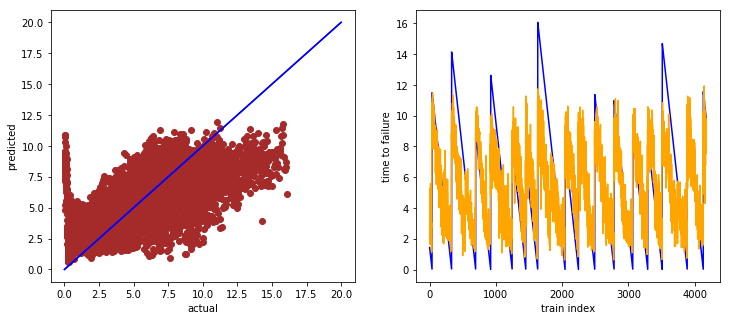

In [49]:
xgb_params = {'eta': 0.05, #Andrew uses 0.03
              'max_depth': 10,
              'subsample': 0.9,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, prediction_xgb, score_mean_xgb, score_std_xgb = train_model(X=X_train_scaled_best,
                                                                     X_test=X_test_scaled_best,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=xgb_params,
                                                                     model_type='xgb',
                                                                     show_scatter=True)

Fold 0 started at Fri Mar  8 14:31:54 2019
Fold 0. MAE: 2.1108.

Fold 1 started at Fri Mar  8 14:31:58 2019
Fold 1. MAE: 2.0792.

Fold 2 started at Fri Mar  8 14:32:01 2019
Fold 2. MAE: 2.2115.

Fold 3 started at Fri Mar  8 14:32:05 2019
Fold 3. MAE: 1.9897.

Fold 4 started at Fri Mar  8 14:32:08 2019
Fold 4. MAE: 2.0762.

CV mean score: 2.0935, std: 0.0714.


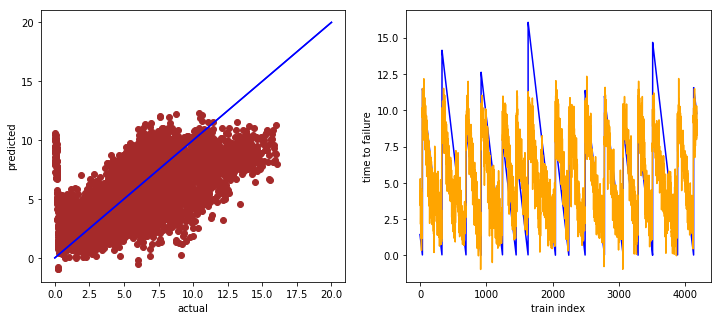

In [50]:
model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01)
oof_svr, prediction_svr, score_mean_svr, score_std_svr = train_model(X=X_train_scaled_best,
                                                                     X_test=X_test_scaled_best,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=None,
                                                                     model_type='sklearn',
                                                                     model=model,
                                                                     show_scatter=True)

Fold 0 started at Fri Mar  8 14:32:12 2019
Fold 0. MAE: 2.0451.

Fold 1 started at Fri Mar  8 14:32:14 2019
Fold 1. MAE: 2.0661.

Fold 2 started at Fri Mar  8 14:32:17 2019
Fold 2. MAE: 2.1431.

Fold 3 started at Fri Mar  8 14:32:19 2019
Fold 3. MAE: 1.9229.

Fold 4 started at Fri Mar  8 14:32:22 2019
Fold 4. MAE: 2.0495.

CV mean score: 2.0454, std: 0.0707.


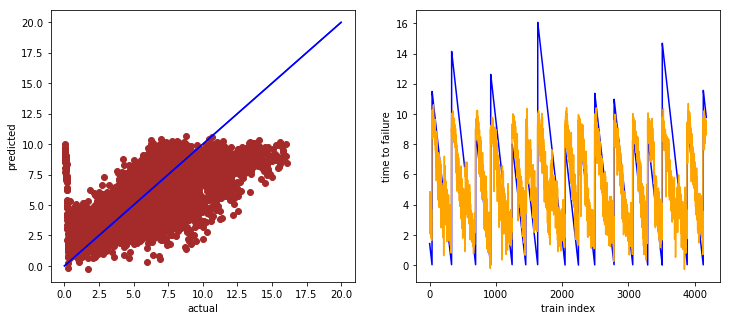

In [51]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
oof_svr1, prediction_svr1, score_mean_svr1, score_std_svr1 = train_model(X=X_train_scaled_best,
                                                                         X_test=X_test_scaled_best,
                                                                         y=y_tr,
                                                                         folds=folds_models,
                                                                         params=None,
                                                                         model_type='sklearn',
                                                                         model=model,
                                                                         show_scatter=True)

Fold 0 started at Fri Mar  8 14:32:25 2019
Fold 1 started at Fri Mar  8 14:35:22 2019
Fold 2 started at Fri Mar  8 14:38:19 2019
Fold 3 started at Fri Mar  8 14:41:16 2019
Fold 4 started at Fri Mar  8 14:44:14 2019
CV mean score: 2.0251, std: 0.0782.


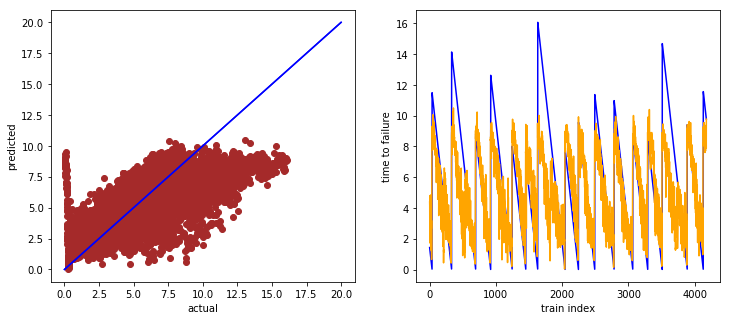

In [52]:
params = {'loss_function':'MAE'}
oof_cat, prediction_cat, score_mean_cat, score_std_cat = train_model(X=X_train_scaled_best,
                                                                     X_test=X_test_scaled_best,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=params,
                                                                     model_type='cat',
                                                                     show_scatter=True)

Fold 0 started at Fri Mar  8 14:47:11 2019
Fold 0. MAE: 2.2185.

Fold 1 started at Fri Mar  8 14:47:12 2019
Fold 1. MAE: 2.2033.

Fold 2 started at Fri Mar  8 14:47:13 2019
Fold 2. MAE: 2.2596.

Fold 3 started at Fri Mar  8 14:47:14 2019
Fold 3. MAE: 2.0584.

Fold 4 started at Fri Mar  8 14:47:15 2019
Fold 4. MAE: 2.1582.

CV mean score: 2.1796, std: 0.0687.


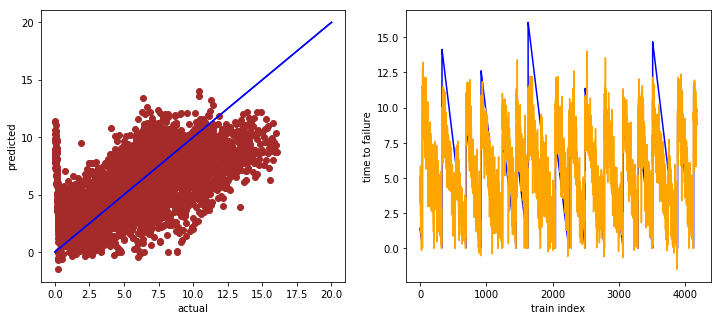

In [53]:
model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
oof_r, prediction_r, score_mean_r, score_std_r = train_model(X=X_train_scaled_best,
                                                             X_test=X_test_scaled_best,
                                                             y=y_tr,
                                                             folds=folds_models,
                                                             params=None,
                                                             model_type='sklearn',
                                                             model=model,
                                                             show_scatter=True)

## Stacking and blending
And now let's try stacking :) We can use the same function for it.

In [54]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr, oof_svr1, oof_r, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr', 'svr1', 'r', 'cat'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_svr, prediction_svr1, prediction_r,
                        prediction_cat]).transpose()
test_stack = pd.DataFrame(test_stack)

In [55]:
oof_lgb_stack, prediction_lgb_stack, score_mean_stack, score_std_stack, feature_importance = train_model(
    X=train_stack,
    X_test=test_stack,
    y=y_tr,
    folds=folds_models,
    params=params,
    model_type='lgb')

Fold 0 started at Fri Mar  8 14:47:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[22]	training's l1: 1.8809	training's l2: 5.75255	valid_1's l1: 2.14062	valid_1's l2: 7.68973
Fold 1 started at Fri Mar  8 14:47:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[27]	training's l1: 1.84644	training's l2: 5.58419	valid_1's l1: 2.10076	valid_1's l2: 7.27927
Fold 2 started at Fri Mar  8 14:47:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[20]	training's l1: 1.89116	training's l2: 5.76175	valid_1's l1: 2.19373	valid_1's l2: 8.04031
Fold 3 started at Fri Mar  8 14:47:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[27]	training's l1: 1.87594	training's l2: 5.77784	valid_1's l1: 1.94436	valid_1's l2: 6.30418
Fold 4 started at Fri Mar  8 14:47:17 2019
Training until

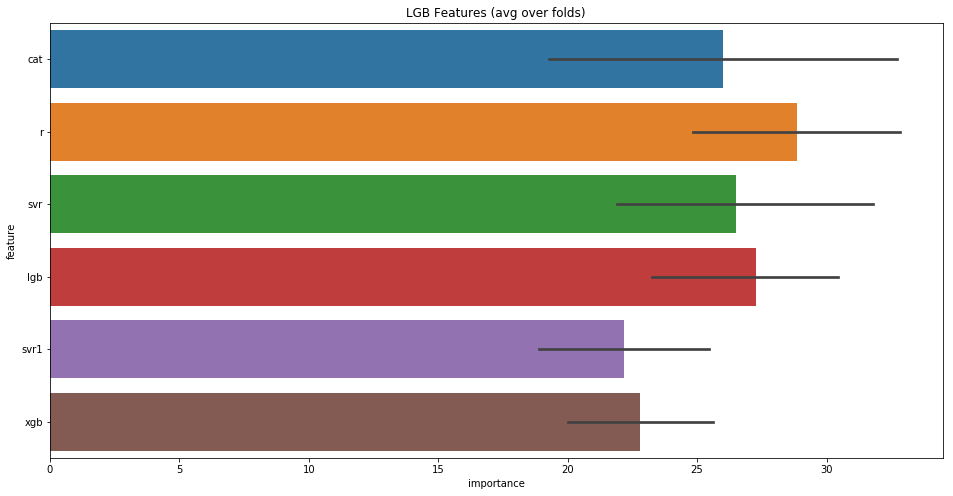

In [56]:
cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(
    by='importance', ascending=False).index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
plt.figure(figsize=(16, 8));
sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False));
plt.title('LGB Features (avg over folds)');

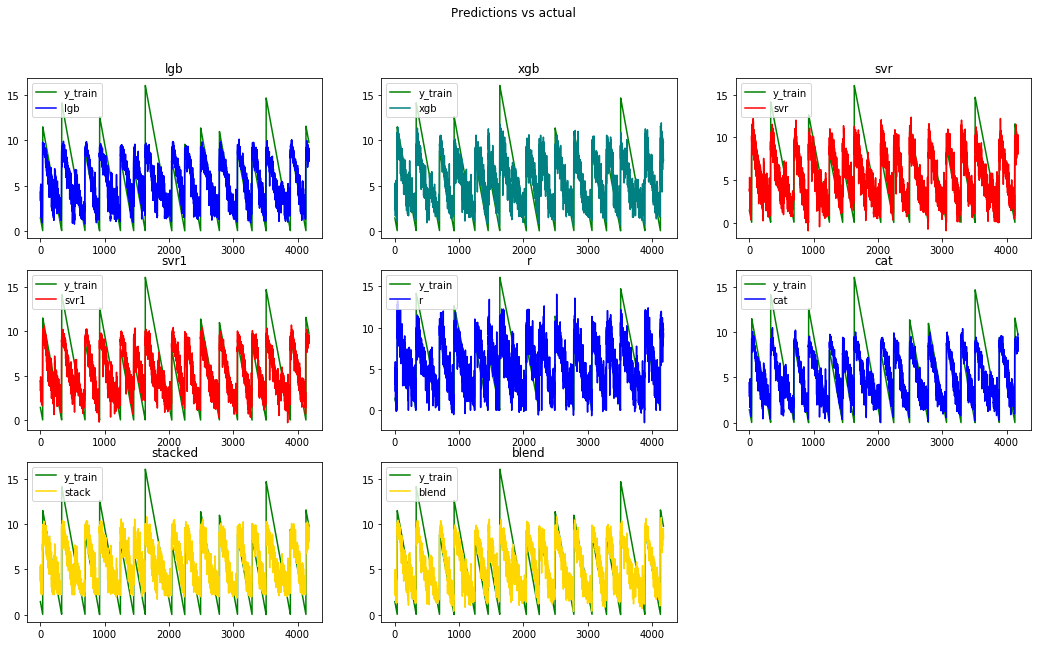

In [60]:
plt.figure(figsize=(18, 10))
plt.subplot(3, 3, 1)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.legend()
plt.title('lgb');

plt.subplot(3, 3, 2)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_xgb, color='teal', label='xgb')
plt.legend()
plt.title('xgb');

plt.subplot(3, 3, 3)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_svr, color='red', label='svr')
plt.legend()
plt.title('svr');

plt.subplot(3, 3, 4)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_svr1, color='red', label='svr1')
plt.legend()
plt.title('svr1');

plt.subplot(3, 3, 5)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_r, color='b', label='r')
plt.legend()
plt.title('r');

plt.subplot(3, 3, 6)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_cat, color='b', label='cat')
plt.legend()
plt.title('cat');

plt.subplot(3, 3, 7)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb_stack, color='gold', label='stack')
plt.legend()
plt.title('stacked');

plt.subplot(3, 3, 8)
plt.plot(y_tr, color='g', label='y_train')
plt.plot((oof_lgb + oof_xgb + oof_svr + oof_svr1 + oof_r + oof_cat) / 6, color='gold', label='blend')
plt.legend()
plt.title('blend');
plt.suptitle('Predictions vs actual');

### Submission - Blend model

In [58]:
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr +
                                 prediction_svr1 + prediction_cat + prediction_r) / 6
submission.to_csv('../output/submission_rdg_notebook3_blend.csv')
score_mean_blend = (score_mean_lgb + score_mean_xgb + score_mean_svr + score_mean_svr1 + score_mean_cat
                    + score_mean_r) / 6
score_std_blend = (score_std_lgb + score_std_xgb + score_std_svr + score_std_svr1 + score_std_cat
                    + score_std_r) / 6
print(f'CV mean score: {score_mean_blend:.4f}, std: {score_std_blend:.4f}.')

CV mean score: 2.0759, std: 0.0749.


### Submission - Stacked model

In [59]:
submission['time_to_failure'] = prediction_lgb_stack
submission.to_csv('../output/submission_rdg_notebook3_stack.csv')
print(f'CV mean score: {score_mean_stack:.4f}, std: {score_std_stack:.4f}.')

CV mean score: 2.0974, std: 0.0833.


In [65]:
evaluation = pd.DataFrame(dtype=np.float64)

In [69]:
evaluation.loc['lgb', 'mean'] = score_mean_lgb
evaluation.loc['lgb', 'std'] = score_std_lgb

evaluation.loc['xgb', 'mean'] = score_mean_xgb
evaluation.loc['xgb', 'std'] = score_std_xgb

evaluation.loc['svr', 'mean'] = score_mean_svr
evaluation.loc['svr', 'std'] = score_std_svr

evaluation.loc['svr1', 'mean'] = score_mean_svr1
evaluation.loc['svr1', 'std'] = score_std_svr1

evaluation.loc['cat', 'mean'] = score_mean_cat
evaluation.loc['cat', 'std'] = score_std_cat

evaluation.loc['r', 'mean'] = score_mean_r
evaluation.loc['r', 'std'] = score_std_r

evaluation.loc['blend', 'mean'] = score_mean_r
evaluation.loc['blend', 'std'] = score_std_r

evaluation.loc['stack', 'mean'] = score_mean_stack
evaluation.loc['stack', 'std'] = score_std_stack

In [70]:
evaluation

,mean,std
lgb,2.031931925749908,0.077618062861863
xgb,2.080176564058465,0.082451059714294
svr,2.093467493384435,0.071445408131889
svr1,2.045356688408060,0.070698769354133
cat,2.025052636089567,0.078218960276675
r,2.179602108247257,0.068724788494891
blend,2.179602108247257,0.068724788494891
stack,2.097371217371202,0.083283171311776


In [ ]:
plt.figure(figsize=(16, 8));
sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False));
plt.title('LGB Features (avg over folds)');